In [1]:
#importing all required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from pykalman import KalmanFilter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Plotly.express module can plot interactive plots easily and effectively.

In [2]:

# Load CSV file and parse the 'Date' column as dates
transformed_df = pd.read_csv("transformed_returns_(2015-2019).csv", parse_dates=['Date'], index_col='Date')

# Display the first few rows to check if the file was loaded correctly
transformed_df.head()

,Market_Returns,Asset_Returns
Date,,
2015-01-02,0.000000,0.000000
2015-01-05,-0.018278,-0.016890
2015-01-06,-0.008894,-0.030319
2015-01-07,0.011629,-0.002606
2015-01-08,0.017888,0.037617


# Model B: Kalman Filter for beta estimation in contex to CAPM
---

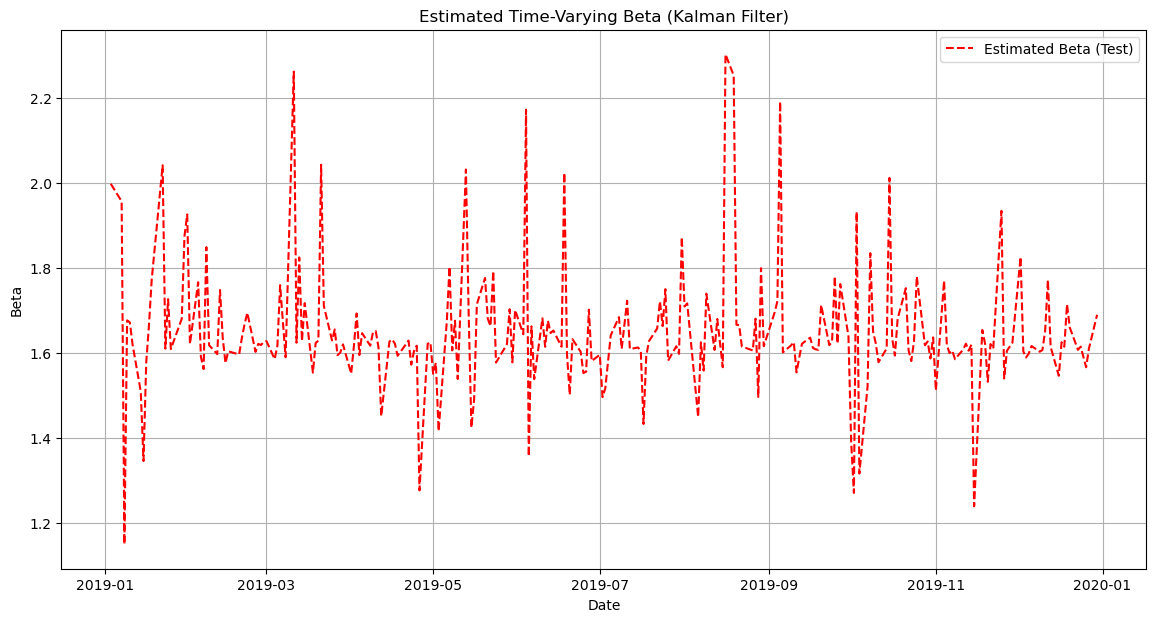

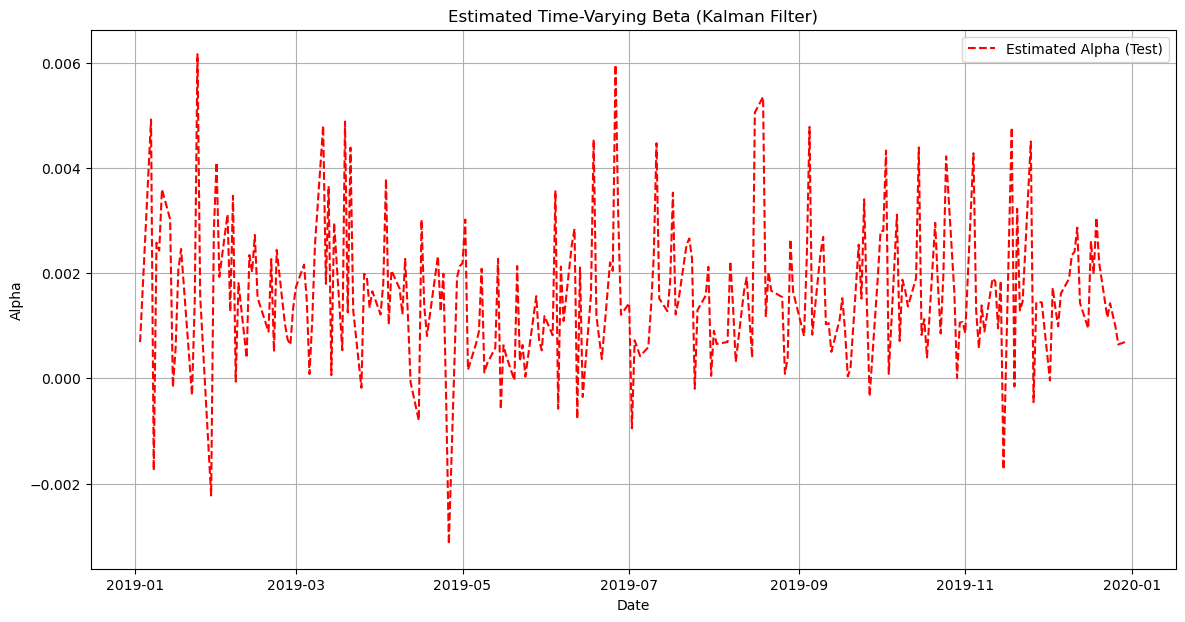

Test RMSE: 0.01473410926131638
Test MAE: 0.011104365170631588
Test R^2: 0.5932360850657885


In [3]:

# Extract the necessary columns for the state-space model, it is better to save into a variable
# and then call them accordingly
observations = transformed_df[['Market_Returns', 'Asset_Returns']]

# Split data into training and testing sets
train_df, test_df = train_test_split(observations, test_size=0.2, shuffle=False)

# Define initial state parameters
initial_state_mean = [0, 1]  # Initial guess for alpha and beta, starting with beta = 1 and alpha = 0
initial_state_covariance = np.eye(2) 

# Construct the observation matrix for the training data
observation_matrices = np.array([
    [1, train_df['Market_Returns'].values[i]] for i in range(len(train_df))
])

# Reshape observation_matrices to have the correct shape for pykalman library
observation_matrices = observation_matrices.reshape(-1, 1, 2)

# Instantiating the model with the parameters
kf = KalmanFilter(
    transition_matrices=np.eye(2),
    observation_matrices=observation_matrices,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance,
    em_vars=['transition_covariance', 'observation_covariance', 'initial_state_covariance']
)

# Apply EM algorithm to training data for optimising our matrices as explained in the report.
kf = kf.em(train_df['Asset_Returns'].values, n_iter=100)

# applying The kalman filter on the training set to estimate the states
state_means, state_covariances = kf.filter(train_df['Asset_Returns'].values)

# Use the filtered states to forecast on the test set
predicted_means = []
predicted_covariances = []

for t in range(len(test_df)):
    observation_matrix_test = np.array([[1, test_df['Market_Returns'].iloc[t]]])
    
    # Update the filter with the new observation recursively inside this loop
    filtered_state_mean, filtered_state_covariance = kf.filter_update(
        filtered_state_mean=state_means[-1], 
        filtered_state_covariance=state_covariances[-1],
        observation=test_df['Asset_Returns'].iloc[t],
        observation_matrix=observation_matrix_test
    )
    
    predicted_means.append(filtered_state_mean)
    predicted_covariances.append(filtered_state_covariance)

predicted_means = np.array(predicted_means)
predicted_covariances = np.array(predicted_covariances)

# saving necessary outputs for plotting
train_estimated_beta = state_means[:, 1]
test_estimated_beta = predicted_means[:, 1]
test_estimated_alpha = predicted_means[:, 0]

# the estimated beta over time
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, test_estimated_beta, label='Estimated Beta (Test)', color='red', linestyle='--')
plt.title('Estimated Time-Varying Beta (Kalman Filter)')
plt.xlabel('Date')
plt.ylabel('Beta')
plt.legend()
plt.grid(True)
plt.show()

# the estimated beta over time
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, test_estimated_alpha, label='Estimated Alpha (Test)', color='red', linestyle='--')
plt.title('Estimated Time-Varying Beta (Kalman Filter)')
plt.xlabel('Date')
plt.ylabel('Alpha')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE, MAE, R^2 on the test set
test_predictions = np.array([np.dot(np.array([[1, test_df['Market_Returns'].iloc[t]]]), mean) for t, mean in enumerate(predicted_means)])

rmse = np.sqrt(mean_squared_error(test_df['Asset_Returns'], test_predictions))
mae = mean_absolute_error(test_df['Asset_Returns'], test_predictions)
r_squared = r2_score(test_df['Asset_Returns'], test_predictions)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test R^2: {r_squared}')


Predicted Asset Returns - Test RMSE: 0.01473410926131638
Predicted Asset Returns - Test MAE: 0.011104365170631588
Predicted Asset Returns - Test R^2: 0.5932360850657885


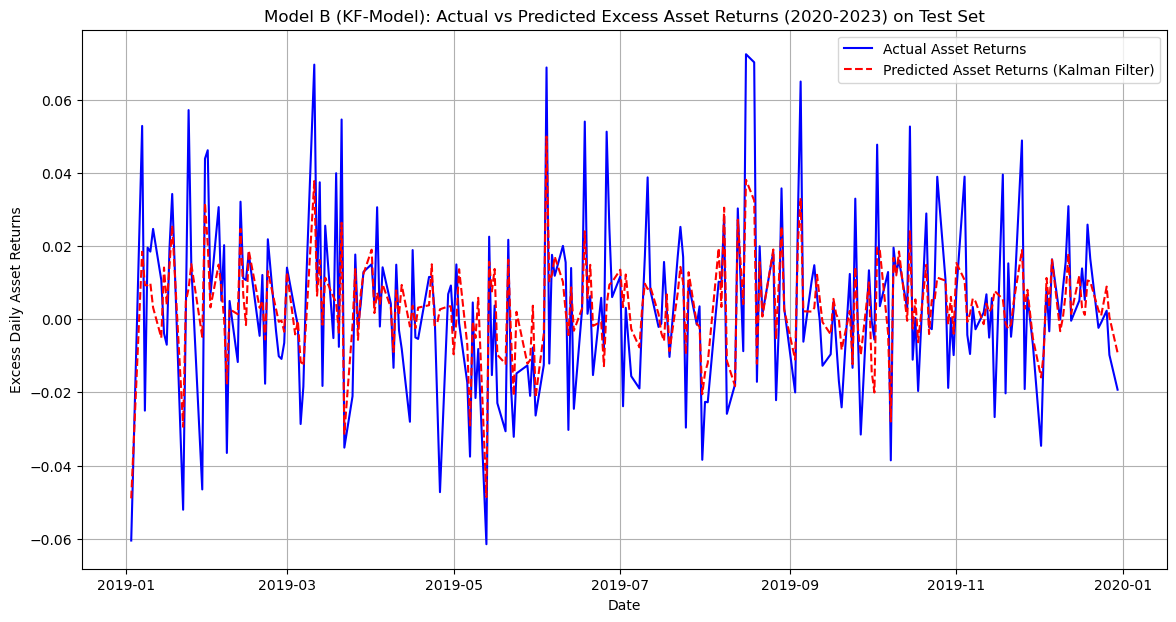

In [4]:

# Predict asset returns using the estimated betas using CAPM equation
# Asset_Returns = alpha + beta * Market_Returns, here the idiosyncratic noise is missing which is the error of the model in a way.
predicted_asset_returns = np.array([pred[0] + pred[1] * test_df['Market_Returns'].iloc[t] 
                                    for t, pred in enumerate(predicted_means)])

# Step 2: Calculate the evaluation metrics on the predicted asset returns
rmse_asset = np.sqrt(mean_squared_error(test_df['Asset_Returns'], predicted_asset_returns))
mae_asset = mean_absolute_error(test_df['Asset_Returns'], predicted_asset_returns)
r2_asset = r2_score(test_df['Asset_Returns'], predicted_asset_returns)


print(f'Predicted Asset Returns - Test RMSE: {rmse_asset}')
print(f'Predicted Asset Returns - Test MAE: {mae_asset}')
print(f'Predicted Asset Returns - Test R^2: {r2_asset}')


# Step 3: Plot the actual vs predicted asset returns for the test set
plt.figure(figsize=(14, 7))
plt.plot(test_df.index, test_df['Asset_Returns'], label='Actual Asset Returns', color='blue')
plt.plot(test_df.index, predicted_asset_returns, label='Predicted Asset Returns (Kalman Filter)', color='red', linestyle='--')
plt.title('Model B (KF-Model): Actual vs Predicted Excess Asset Returns (2020-2023) on Test Set')
plt.xlabel('Date')
plt.ylabel('Excess Daily Asset Returns')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, save the predicted asset returns to a CSV for further analysis
# this code can be commented out to save the file and see it as a dataframe
# predicted_asset_returns_df = pd.DataFrame({'Date': test_df.index, 'Predicted_Asset_Returns': predicted_asset_returns})
# predicted_asset_returns_df.to_csv('predicted_asset_returns_kalman(2015-2019).csv', index=True)


### Interactive Plot to see with added granularity

In [5]:


# Create traces
fig = go.Figure()

# Actual Asset Returns
fig.add_trace(go.Scatter(x=test_df.index, 
                         y=test_df['Asset_Returns'], 
                         mode='lines', 
                         name='Actual Asset Returns',
                         line=dict(color='blue')))

# Predicted Asset Returns
fig.add_trace(go.Scatter(x=test_df.index, 
                         y=predicted_asset_returns, 
                         mode='lines', 
                         name='Predicted Asset Returns (Kalman Filter)',
                         line=dict(color='red', dash='dash')))

# Update layout
fig.update_layout(title='Actual vs Predicted Asset Returns (Kalman Filter)',
                  xaxis_title='Date',
                  yaxis_title='Asset Returns',
                  legend=dict(x=0, y=1.0),
                  hovermode='x unified')

# Show the figure
fig.show()
